https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Importing Libraries
import os
import copy
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [3]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [4]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [5]:
cdata = GetCIFAR10_TrainData(os.chdir(".."))
trainset = cdata.download_train_data()
testset = cdata.download_test_data()

VALID_RATIO = 0.9
n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

trainset, validset = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])

validset = copy.deepcopy(validset)
validset.dataset.transform = test_transforms

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
len(trainset), len(validset), len(testset)

(45000, 5000, 10000)

In [7]:
BATCH_SIZE = 512

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# The Model - RESNET18


In [8]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [9]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        # self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        # self.fc = nn.Linear(256, num_classes)
        self.fc = nn.Linear(1024, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    # return ResNet(ResidualBlock, [2, 2, 2, 2])
    return ResNet(ResidualBlock, [3, 4, 3])

In [10]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
             ReLU-11           [-1, 64, 32, 32]               0
    ResidualBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [11]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        # train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        
        # print statistics
        
        running_loss += loss.item()
        pbar.set_description(desc=f'Batch_id={batch_idx} Batch Loss={loss.item()} Running Loss={running_loss} Running Accuracy={100*correct/processed:0.2f}')
        # train_acc.append(100*correct/processed)
    
    train_losses.append(running_loss)
    train_acc.append(100*correct/processed)

In [12]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified, correct / len(test_dataloader.dataset)

In [13]:
def model_evaluation(model, device, loader):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in loader:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = F.nll_loss(y_pred, y)
        
            pred = y_pred.argmax(dim=1, keepdim=True)
            acc = pred.eq(y.view_as(pred)).sum()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    epoch_loss / len(loader.dataset), epoch_acc, len(loader.dataset),
    100. * epoch_acc / len(loader.dataset)))

    return epoch_loss, epoch_acc / len(loader.dataset)

In [14]:
# Defining parameters

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [15]:
import pandas

def save_to_csv(csvname, train_losses, train_accs, test_losses, test_accs):
  df = pandas.DataFrame()
  df["epoch"] = [i+1 for i in range(len(train_losses))]
  df["train_loss"] = train_losses
  df["test_loss"] = test_losses
  df["train_acc"] = train_accs
  df["test_acc"] = test_accs
  df.to_csv(csvname)

In [16]:
# Training the model

train_acc = []
train_losses = []
valid_accs = []
valid_losses = []
test_acc = []
test_losses = []
min_valid_loss = None
max_acc = None

EPOCHS = 120

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)

    # Validating the model for the current epoch
    valid_loss, valid_acc = model_evaluation(model, device, validloader)  

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    if not min_valid_loss:
      min_valid_loss = valid_loss
    else:
      if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        torch.save(model, "best_model.pickle")

    scheduler.step(train_losses[-1])
    # scheduler.step(valid_loss)

    misclassified, test_acc2 = model_testing(model, device, testloader, test_acc, test_losses)

    if not max_acc:
      max_acc = test_acc2
    else:
      if test_acc2 > max_acc:
        max_acc = test_acc2
        torch.save(model, "best_test_acc_model.pickle")

    save_to_csv("13_resnet_3_4_3_inchannels_64.csv", train_losses, train_acc, test_losses, test_acc)


EPOCHS : 0


Batch_id=87 Batch Loss=1.4170489311218262 Running Loss=153.4842507839203 Running Accuracy=35.98: 100%|██████████| 88/88 [00:49<00:00,  1.79it/s]



Validation set: Average loss: 0.0028, Accuracy: 2478/5000 (49.56%)


Test set: Average loss: 1.4022, Accuracy: 5040/10000 (50.40%)

EPOCHS : 1


Batch_id=87 Batch Loss=1.1747334003448486 Running Loss=116.00295579433441 Running Accuracy=52.58: 100%|██████████| 88/88 [00:50<00:00,  1.75it/s]



Validation set: Average loss: 0.0021, Accuracy: 3079/5000 (61.58%)


Test set: Average loss: 1.0688, Accuracy: 6162/10000 (61.62%)

EPOCHS : 2


Batch_id=87 Batch Loss=1.0874477624893188 Running Loss=97.3460903763771 Running Accuracy=60.57: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0020, Accuracy: 3269/5000 (65.38%)


Test set: Average loss: 1.0201, Accuracy: 6532/10000 (65.32%)

EPOCHS : 3


Batch_id=87 Batch Loss=0.974215030670166 Running Loss=85.996098279953 Running Accuracy=65.29: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0018, Accuracy: 3465/5000 (69.30%)


Test set: Average loss: 0.8949, Accuracy: 6932/10000 (69.32%)

EPOCHS : 4


Batch_id=87 Batch Loss=0.7401211857795715 Running Loss=74.59105789661407 Running Accuracy=69.92: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0015, Accuracy: 3657/5000 (73.14%)


Test set: Average loss: 0.7692, Accuracy: 7334/10000 (73.34%)

EPOCHS : 5


Batch_id=87 Batch Loss=0.7538799047470093 Running Loss=68.06900811195374 Running Accuracy=72.60: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0014, Accuracy: 3805/5000 (76.10%)


Test set: Average loss: 0.7385, Accuracy: 7495/10000 (74.95%)

EPOCHS : 6


Batch_id=87 Batch Loss=0.6202577352523804 Running Loss=62.62460297346115 Running Accuracy=75.09: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0012, Accuracy: 3948/5000 (78.96%)


Test set: Average loss: 0.6633, Accuracy: 7740/10000 (77.40%)

EPOCHS : 7


Batch_id=87 Batch Loss=0.5990933179855347 Running Loss=59.25406241416931 Running Accuracy=76.33: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0011, Accuracy: 3999/5000 (79.98%)


Test set: Average loss: 0.5949, Accuracy: 7977/10000 (79.77%)

EPOCHS : 8


Batch_id=87 Batch Loss=0.6738110780715942 Running Loss=54.953682005405426 Running Accuracy=78.11: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0012, Accuracy: 3944/5000 (78.88%)


Test set: Average loss: 0.6517, Accuracy: 7852/10000 (78.52%)

EPOCHS : 9


Batch_id=87 Batch Loss=0.6210492253303528 Running Loss=52.81561726331711 Running Accuracy=78.76: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0012, Accuracy: 4039/5000 (80.78%)


Test set: Average loss: 0.6153, Accuracy: 7992/10000 (79.92%)

EPOCHS : 10


Batch_id=87 Batch Loss=0.5633490085601807 Running Loss=50.03006273508072 Running Accuracy=80.15: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0011, Accuracy: 4082/5000 (81.64%)


Test set: Average loss: 0.5746, Accuracy: 8116/10000 (81.16%)

EPOCHS : 11


Batch_id=87 Batch Loss=0.5766981244087219 Running Loss=47.32274994254112 Running Accuracy=81.06: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0011, Accuracy: 4090/5000 (81.80%)


Test set: Average loss: 0.5986, Accuracy: 8043/10000 (80.43%)

EPOCHS : 12


Batch_id=87 Batch Loss=0.4756104648113251 Running Loss=44.89047992229462 Running Accuracy=82.03: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0013, Accuracy: 3934/5000 (78.68%)


Test set: Average loss: 0.6788, Accuracy: 7886/10000 (78.86%)

EPOCHS : 13


Batch_id=87 Batch Loss=0.5036187767982483 Running Loss=41.77852672338486 Running Accuracy=83.32: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0010, Accuracy: 4129/5000 (82.58%)


Test set: Average loss: 0.5204, Accuracy: 8309/10000 (83.09%)

EPOCHS : 14


Batch_id=87 Batch Loss=0.5220705270767212 Running Loss=41.042870074510574 Running Accuracy=83.57: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0009, Accuracy: 4284/5000 (85.68%)


Test set: Average loss: 0.4552, Accuracy: 8461/10000 (84.61%)

EPOCHS : 15


Batch_id=87 Batch Loss=0.5328029990196228 Running Loss=40.18190059065819 Running Accuracy=84.10: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4328/5000 (86.56%)


Test set: Average loss: 0.4154, Accuracy: 8585/10000 (85.85%)

EPOCHS : 16


Batch_id=87 Batch Loss=0.5153507590293884 Running Loss=37.75802254676819 Running Accuracy=84.98: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4362/5000 (87.24%)


Test set: Average loss: 0.4209, Accuracy: 8598/10000 (85.98%)

EPOCHS : 17


Batch_id=87 Batch Loss=0.39802175760269165 Running Loss=35.932539224624634 Running Accuracy=85.64: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0009, Accuracy: 4301/5000 (86.02%)


Test set: Average loss: 0.4652, Accuracy: 8476/10000 (84.76%)

EPOCHS : 18


Batch_id=87 Batch Loss=0.39835330843925476 Running Loss=34.96349447965622 Running Accuracy=85.96: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4361/5000 (87.22%)


Test set: Average loss: 0.4252, Accuracy: 8555/10000 (85.55%)

EPOCHS : 19


Batch_id=87 Batch Loss=0.4087240993976593 Running Loss=33.877252608537674 Running Accuracy=86.44: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4350/5000 (87.00%)


Test set: Average loss: 0.4424, Accuracy: 8564/10000 (85.64%)

EPOCHS : 20


Batch_id=87 Batch Loss=0.4684199094772339 Running Loss=33.19009095430374 Running Accuracy=86.72: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0009, Accuracy: 4299/5000 (85.98%)


Test set: Average loss: 0.4659, Accuracy: 8476/10000 (84.76%)

EPOCHS : 21


Batch_id=87 Batch Loss=0.4330686628818512 Running Loss=31.904059201478958 Running Accuracy=87.14: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4320/5000 (86.40%)


Test set: Average loss: 0.4544, Accuracy: 8516/10000 (85.16%)

EPOCHS : 22


Batch_id=87 Batch Loss=0.3618643581867218 Running Loss=30.594562530517578 Running Accuracy=87.88: 100%|██████████| 88/88 [00:51<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4408/5000 (88.16%)


Test set: Average loss: 0.3904, Accuracy: 8704/10000 (87.04%)

EPOCHS : 23


Batch_id=87 Batch Loss=0.3938840627670288 Running Loss=28.987977862358093 Running Accuracy=88.32: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4440/5000 (88.80%)


Test set: Average loss: 0.3986, Accuracy: 8724/10000 (87.24%)

EPOCHS : 24


Batch_id=87 Batch Loss=0.27723968029022217 Running Loss=28.685218140482903 Running Accuracy=88.57: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4455/5000 (89.10%)


Test set: Average loss: 0.3795, Accuracy: 8781/10000 (87.81%)

EPOCHS : 25


Batch_id=87 Batch Loss=0.3454152047634125 Running Loss=27.77372394502163 Running Accuracy=88.88: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4416/5000 (88.32%)


Test set: Average loss: 0.4055, Accuracy: 8686/10000 (86.86%)

EPOCHS : 26


Batch_id=87 Batch Loss=0.2951801121234894 Running Loss=26.889332368969917 Running Accuracy=89.29: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4420/5000 (88.40%)


Test set: Average loss: 0.3745, Accuracy: 8781/10000 (87.81%)

EPOCHS : 27


Batch_id=87 Batch Loss=0.3192775845527649 Running Loss=26.986842051148415 Running Accuracy=89.08: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0008, Accuracy: 4392/5000 (87.84%)


Test set: Average loss: 0.4127, Accuracy: 8698/10000 (86.98%)

EPOCHS : 28


Batch_id=87 Batch Loss=0.3608924150466919 Running Loss=26.10966596007347 Running Accuracy=89.68: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4414/5000 (88.28%)


Test set: Average loss: 0.3924, Accuracy: 8750/10000 (87.50%)

EPOCHS : 29


Batch_id=87 Batch Loss=0.26273226737976074 Running Loss=24.497234970331192 Running Accuracy=90.31: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4436/5000 (88.72%)


Test set: Average loss: 0.3817, Accuracy: 8804/10000 (88.04%)

EPOCHS : 30


Batch_id=87 Batch Loss=0.31000304222106934 Running Loss=24.791407257318497 Running Accuracy=90.05: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4421/5000 (88.42%)


Test set: Average loss: 0.4023, Accuracy: 8784/10000 (87.84%)

EPOCHS : 31


Batch_id=87 Batch Loss=0.24692362546920776 Running Loss=23.893571943044662 Running Accuracy=90.56: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4460/5000 (89.20%)


Test set: Average loss: 0.3712, Accuracy: 8817/10000 (88.17%)

EPOCHS : 32


Batch_id=87 Batch Loss=0.23755446076393127 Running Loss=22.85487899184227 Running Accuracy=90.73: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4435/5000 (88.70%)


Test set: Average loss: 0.4023, Accuracy: 8772/10000 (87.72%)

EPOCHS : 33


Batch_id=87 Batch Loss=0.3350081443786621 Running Loss=23.0489688962698 Running Accuracy=90.72: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4426/5000 (88.52%)


Test set: Average loss: 0.4070, Accuracy: 8753/10000 (87.53%)

EPOCHS : 34


Batch_id=87 Batch Loss=0.2614912986755371 Running Loss=21.54668155312538 Running Accuracy=91.45: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4534/5000 (90.68%)


Test set: Average loss: 0.3405, Accuracy: 8959/10000 (89.59%)

EPOCHS : 35


Batch_id=87 Batch Loss=0.23835183680057526 Running Loss=20.207038655877113 Running Accuracy=91.99: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4493/5000 (89.86%)


Test set: Average loss: 0.3534, Accuracy: 8947/10000 (89.47%)

EPOCHS : 36


Batch_id=87 Batch Loss=0.2374633252620697 Running Loss=20.502774640917778 Running Accuracy=91.81: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4470/5000 (89.40%)


Test set: Average loss: 0.3796, Accuracy: 8856/10000 (88.56%)

EPOCHS : 37


Batch_id=87 Batch Loss=0.22731029987335205 Running Loss=19.998944491147995 Running Accuracy=91.95: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4449/5000 (88.98%)


Test set: Average loss: 0.3985, Accuracy: 8788/10000 (87.88%)

EPOCHS : 38


Batch_id=87 Batch Loss=0.24860817193984985 Running Loss=19.726325795054436 Running Accuracy=92.02: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4507/5000 (90.14%)


Test set: Average loss: 0.3830, Accuracy: 8854/10000 (88.54%)

EPOCHS : 39


Batch_id=87 Batch Loss=0.24989579617977142 Running Loss=19.716916367411613 Running Accuracy=92.05: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4539/5000 (90.78%)


Test set: Average loss: 0.3385, Accuracy: 8946/10000 (89.46%)

EPOCHS : 40


Batch_id=87 Batch Loss=0.2565852999687195 Running Loss=18.555570244789124 Running Accuracy=92.42: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4500/5000 (90.00%)


Test set: Average loss: 0.3459, Accuracy: 8917/10000 (89.17%)

EPOCHS : 41


Batch_id=87 Batch Loss=0.21313002705574036 Running Loss=17.996566087007523 Running Accuracy=92.61: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4484/5000 (89.68%)


Test set: Average loss: 0.3646, Accuracy: 8923/10000 (89.23%)

EPOCHS : 42


Batch_id=87 Batch Loss=0.21013738214969635 Running Loss=17.752879455685616 Running Accuracy=92.82: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4535/5000 (90.70%)


Test set: Average loss: 0.3396, Accuracy: 9012/10000 (90.12%)

EPOCHS : 43


Batch_id=87 Batch Loss=0.18440303206443787 Running Loss=17.513336956501007 Running Accuracy=92.89: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4509/5000 (90.18%)


Test set: Average loss: 0.3601, Accuracy: 8905/10000 (89.05%)

EPOCHS : 44


Batch_id=87 Batch Loss=0.18547064065933228 Running Loss=17.10250647366047 Running Accuracy=92.98: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4538/5000 (90.76%)


Test set: Average loss: 0.3450, Accuracy: 8968/10000 (89.68%)

EPOCHS : 45


Batch_id=87 Batch Loss=0.2146807163953781 Running Loss=16.50309406220913 Running Accuracy=93.50: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4528/5000 (90.56%)


Test set: Average loss: 0.3208, Accuracy: 9045/10000 (90.45%)

EPOCHS : 46


Batch_id=87 Batch Loss=0.21478570997714996 Running Loss=15.878394946455956 Running Accuracy=93.64: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4526/5000 (90.52%)


Test set: Average loss: 0.3451, Accuracy: 8969/10000 (89.69%)

EPOCHS : 47


Batch_id=87 Batch Loss=0.16949613392353058 Running Loss=15.88985288143158 Running Accuracy=93.67: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4519/5000 (90.38%)


Test set: Average loss: 0.3671, Accuracy: 8876/10000 (88.76%)

EPOCHS : 48


Batch_id=87 Batch Loss=0.16665960848331451 Running Loss=15.54572831094265 Running Accuracy=93.63: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4509/5000 (90.18%)


Test set: Average loss: 0.3689, Accuracy: 8946/10000 (89.46%)

EPOCHS : 49


Batch_id=87 Batch Loss=0.14985817670822144 Running Loss=15.171079613268375 Running Accuracy=93.79: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4550/5000 (91.00%)


Test set: Average loss: 0.3444, Accuracy: 9032/10000 (90.32%)

EPOCHS : 50


Batch_id=87 Batch Loss=0.19833725690841675 Running Loss=15.13410148769617 Running Accuracy=93.83: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4454/5000 (89.08%)


Test set: Average loss: 0.4404, Accuracy: 8788/10000 (87.88%)

EPOCHS : 51


Batch_id=87 Batch Loss=0.1490522176027298 Running Loss=14.398986041545868 Running Accuracy=94.10: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4572/5000 (91.44%)


Test set: Average loss: 0.3440, Accuracy: 9029/10000 (90.29%)

EPOCHS : 52


Batch_id=87 Batch Loss=0.13537879288196564 Running Loss=14.290464647114277 Running Accuracy=94.20: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4584/5000 (91.68%)


Test set: Average loss: 0.3300, Accuracy: 9066/10000 (90.66%)

EPOCHS : 53


Batch_id=87 Batch Loss=0.1283566951751709 Running Loss=14.011640638113022 Running Accuracy=94.29: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4526/5000 (90.52%)


Test set: Average loss: 0.3801, Accuracy: 8944/10000 (89.44%)

EPOCHS : 54


Batch_id=87 Batch Loss=0.13725033402442932 Running Loss=13.539752148091793 Running Accuracy=94.54: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4512/5000 (90.24%)


Test set: Average loss: 0.3642, Accuracy: 8938/10000 (89.38%)

EPOCHS : 55


Batch_id=87 Batch Loss=0.15481795370578766 Running Loss=13.68734659999609 Running Accuracy=94.43: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4510/5000 (90.20%)


Test set: Average loss: 0.3761, Accuracy: 8937/10000 (89.37%)

EPOCHS : 56


Batch_id=87 Batch Loss=0.16814254224300385 Running Loss=13.307151384651661 Running Accuracy=94.62: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4529/5000 (90.58%)


Test set: Average loss: 0.3496, Accuracy: 8991/10000 (89.91%)

EPOCHS : 57


Batch_id=87 Batch Loss=0.15083812177181244 Running Loss=12.732885479927063 Running Accuracy=94.79: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4454/5000 (89.08%)


Test set: Average loss: 0.4141, Accuracy: 8867/10000 (88.67%)

EPOCHS : 58


Batch_id=87 Batch Loss=0.15520082414150238 Running Loss=12.36491660028696 Running Accuracy=95.06: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4457/5000 (89.14%)


Test set: Average loss: 0.4139, Accuracy: 8843/10000 (88.43%)

EPOCHS : 59


Batch_id=87 Batch Loss=0.1723979264497757 Running Loss=12.11918082088232 Running Accuracy=95.09: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4562/5000 (91.24%)


Test set: Average loss: 0.3706, Accuracy: 8964/10000 (89.64%)

EPOCHS : 60


Batch_id=87 Batch Loss=0.18885308504104614 Running Loss=12.035838350653648 Running Accuracy=95.14: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.3541, Accuracy: 9028/10000 (90.28%)

EPOCHS : 61


Batch_id=87 Batch Loss=0.14685724675655365 Running Loss=11.638543091714382 Running Accuracy=95.28: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4567/5000 (91.34%)


Test set: Average loss: 0.3455, Accuracy: 9033/10000 (90.33%)

EPOCHS : 62


Batch_id=87 Batch Loss=0.13827486336231232 Running Loss=11.621681541204453 Running Accuracy=95.27: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4517/5000 (90.34%)


Test set: Average loss: 0.3940, Accuracy: 8948/10000 (89.48%)

EPOCHS : 63


Batch_id=87 Batch Loss=0.14935897290706635 Running Loss=11.706002987921238 Running Accuracy=95.16: 100%|██████████| 88/88 [00:51<00:00,  1.71it/s]



Validation set: Average loss: 0.0006, Accuracy: 4572/5000 (91.44%)


Test set: Average loss: 0.3585, Accuracy: 9042/10000 (90.42%)

EPOCHS : 64


Batch_id=87 Batch Loss=0.12345212697982788 Running Loss=10.900008425116539 Running Accuracy=95.59: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4539/5000 (90.78%)


Test set: Average loss: 0.3413, Accuracy: 9061/10000 (90.61%)

EPOCHS : 65


Batch_id=87 Batch Loss=0.12025579810142517 Running Loss=10.53640902787447 Running Accuracy=95.68: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4562/5000 (91.24%)


Test set: Average loss: 0.3448, Accuracy: 9051/10000 (90.51%)

EPOCHS : 66


Batch_id=87 Batch Loss=0.10392862558364868 Running Loss=10.825695961713791 Running Accuracy=95.56: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4539/5000 (90.78%)


Test set: Average loss: 0.3733, Accuracy: 8990/10000 (89.90%)

EPOCHS : 67


Batch_id=87 Batch Loss=0.12845288217067719 Running Loss=10.297531075775623 Running Accuracy=95.76: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4560/5000 (91.20%)


Test set: Average loss: 0.3637, Accuracy: 9037/10000 (90.37%)

EPOCHS : 68


Batch_id=87 Batch Loss=0.137717142701149 Running Loss=10.416558429598808 Running Accuracy=95.78: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4505/5000 (90.10%)


Test set: Average loss: 0.3828, Accuracy: 8972/10000 (89.72%)

EPOCHS : 69


Batch_id=87 Batch Loss=0.10939890146255493 Running Loss=10.064281970262527 Running Accuracy=95.92: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4549/5000 (90.98%)


Test set: Average loss: 0.3663, Accuracy: 9038/10000 (90.38%)

EPOCHS : 70


Batch_id=87 Batch Loss=0.10909950733184814 Running Loss=9.613912664353848 Running Accuracy=96.14: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4553/5000 (91.06%)


Test set: Average loss: 0.3642, Accuracy: 9043/10000 (90.43%)

EPOCHS : 71


Batch_id=87 Batch Loss=0.13523797690868378 Running Loss=9.574827954173088 Running Accuracy=95.98: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4574/5000 (91.48%)


Test set: Average loss: 0.3553, Accuracy: 9063/10000 (90.63%)

EPOCHS : 72


Batch_id=87 Batch Loss=0.10734455287456512 Running Loss=9.165941413491964 Running Accuracy=96.28: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4533/5000 (90.66%)


Test set: Average loss: 0.3805, Accuracy: 9007/10000 (90.07%)

EPOCHS : 73


Batch_id=87 Batch Loss=0.11535244435071945 Running Loss=9.807539537549019 Running Accuracy=96.08: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4565/5000 (91.30%)


Test set: Average loss: 0.3517, Accuracy: 9048/10000 (90.48%)

EPOCHS : 74


Batch_id=87 Batch Loss=0.09789732843637466 Running Loss=9.193347118794918 Running Accuracy=96.30: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4566/5000 (91.32%)


Test set: Average loss: 0.3764, Accuracy: 9028/10000 (90.28%)

EPOCHS : 75


Batch_id=87 Batch Loss=0.1056998074054718 Running Loss=8.926401995122433 Running Accuracy=96.44: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4597/5000 (91.94%)


Test set: Average loss: 0.3321, Accuracy: 9101/10000 (91.01%)

EPOCHS : 76


Batch_id=87 Batch Loss=0.13274268805980682 Running Loss=8.845994304865599 Running Accuracy=96.41: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4571/5000 (91.42%)


Test set: Average loss: 0.3633, Accuracy: 9033/10000 (90.33%)

EPOCHS : 77


Batch_id=87 Batch Loss=0.1025538370013237 Running Loss=9.074000131338835 Running Accuracy=96.30: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4572/5000 (91.44%)


Test set: Average loss: 0.3676, Accuracy: 9058/10000 (90.58%)

EPOCHS : 78


Batch_id=87 Batch Loss=0.10146233439445496 Running Loss=8.552411049604416 Running Accuracy=96.56: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4554/5000 (91.08%)


Test set: Average loss: 0.3775, Accuracy: 9045/10000 (90.45%)

EPOCHS : 79


Batch_id=87 Batch Loss=0.12092714011669159 Running Loss=8.596161659806967 Running Accuracy=96.54: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4560/5000 (91.20%)


Test set: Average loss: 0.3709, Accuracy: 9048/10000 (90.48%)

EPOCHS : 80


Batch_id=87 Batch Loss=0.11176726222038269 Running Loss=8.499207943677902 Running Accuracy=96.65: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4566/5000 (91.32%)


Test set: Average loss: 0.3696, Accuracy: 9067/10000 (90.67%)

EPOCHS : 81


Batch_id=87 Batch Loss=0.09610531479120255 Running Loss=8.207097548991442 Running Accuracy=96.70: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4601/5000 (92.02%)


Test set: Average loss: 0.3547, Accuracy: 9050/10000 (90.50%)

EPOCHS : 82


Batch_id=87 Batch Loss=0.0940905213356018 Running Loss=7.696919675916433 Running Accuracy=96.89: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4538/5000 (90.76%)


Test set: Average loss: 0.3885, Accuracy: 9010/10000 (90.10%)

EPOCHS : 83


Batch_id=87 Batch Loss=0.12495233118534088 Running Loss=8.149005617946386 Running Accuracy=96.81: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0008, Accuracy: 4526/5000 (90.52%)


Test set: Average loss: 0.4194, Accuracy: 8995/10000 (89.95%)

EPOCHS : 84


Batch_id=87 Batch Loss=0.10273346304893494 Running Loss=7.853133719414473 Running Accuracy=96.84: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4546/5000 (90.92%)


Test set: Average loss: 0.3782, Accuracy: 9038/10000 (90.38%)

EPOCHS : 85


Batch_id=87 Batch Loss=0.10160977393388748 Running Loss=7.53864748775959 Running Accuracy=96.95: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4577/5000 (91.54%)


Test set: Average loss: 0.3817, Accuracy: 9057/10000 (90.57%)

EPOCHS : 86


Batch_id=87 Batch Loss=0.0779241994023323 Running Loss=7.211106460541487 Running Accuracy=97.04: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4587/5000 (91.74%)


Test set: Average loss: 0.3630, Accuracy: 9084/10000 (90.84%)

EPOCHS : 87


Batch_id=87 Batch Loss=0.05539815500378609 Running Loss=7.437228377908468 Running Accuracy=97.06: 100%|██████████| 88/88 [00:50<00:00,  1.73it/s]



Validation set: Average loss: 0.0007, Accuracy: 4570/5000 (91.40%)


Test set: Average loss: 0.3653, Accuracy: 9059/10000 (90.59%)

EPOCHS : 88


Batch_id=87 Batch Loss=0.07362189143896103 Running Loss=7.012180041521788 Running Accuracy=97.12: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4529/5000 (90.58%)


Test set: Average loss: 0.4157, Accuracy: 8996/10000 (89.96%)

EPOCHS : 89


Batch_id=87 Batch Loss=0.08644485473632812 Running Loss=7.041963174939156 Running Accuracy=97.13: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0007, Accuracy: 4586/5000 (91.72%)


Test set: Average loss: 0.3871, Accuracy: 9060/10000 (90.60%)

EPOCHS : 90


Batch_id=87 Batch Loss=0.04993877187371254 Running Loss=7.140562072396278 Running Accuracy=97.15: 100%|██████████| 88/88 [00:51<00:00,  1.73it/s]



Validation set: Average loss: 0.0006, Accuracy: 4580/5000 (91.60%)


Test set: Average loss: 0.3525, Accuracy: 9117/10000 (91.17%)

EPOCHS : 91


Batch_id=87 Batch Loss=0.10395955294370651 Running Loss=7.118903495371342 Running Accuracy=97.14: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0006, Accuracy: 4624/5000 (92.48%)

Epoch 00092: reducing learning rate of group 0 to 1.0000e-03.

Test set: Average loss: 0.3416, Accuracy: 9121/10000 (91.21%)

EPOCHS : 92


Batch_id=87 Batch Loss=0.0405924953520298 Running Loss=4.946102146059275 Running Accuracy=98.06: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4644/5000 (92.88%)


Test set: Average loss: 0.3138, Accuracy: 9185/10000 (91.85%)

EPOCHS : 93


Batch_id=87 Batch Loss=0.039175719022750854 Running Loss=4.012948015704751 Running Accuracy=98.52: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4652/5000 (93.04%)


Test set: Average loss: 0.3125, Accuracy: 9182/10000 (91.82%)

EPOCHS : 94


Batch_id=87 Batch Loss=0.056427810341119766 Running Loss=3.8313504606485367 Running Accuracy=98.54: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4658/5000 (93.16%)


Test set: Average loss: 0.3034, Accuracy: 9201/10000 (92.01%)

EPOCHS : 95


Batch_id=87 Batch Loss=0.04594587907195091 Running Loss=3.6791659370064735 Running Accuracy=98.69: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4662/5000 (93.24%)


Test set: Average loss: 0.3046, Accuracy: 9201/10000 (92.01%)

EPOCHS : 96


Batch_id=87 Batch Loss=0.039928365498781204 Running Loss=3.5376485977321863 Running Accuracy=98.69: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4656/5000 (93.12%)


Test set: Average loss: 0.3091, Accuracy: 9186/10000 (91.86%)

EPOCHS : 97


Batch_id=87 Batch Loss=0.029682857915759087 Running Loss=3.608028369024396 Running Accuracy=98.70: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4653/5000 (93.06%)


Test set: Average loss: 0.3089, Accuracy: 9193/10000 (91.93%)

EPOCHS : 98


Batch_id=87 Batch Loss=0.0351652130484581 Running Loss=3.3451634608209133 Running Accuracy=98.80: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4653/5000 (93.06%)


Test set: Average loss: 0.3051, Accuracy: 9187/10000 (91.87%)

EPOCHS : 99


Batch_id=87 Batch Loss=0.03451361134648323 Running Loss=3.176770517602563 Running Accuracy=98.90: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4657/5000 (93.14%)


Test set: Average loss: 0.3105, Accuracy: 9192/10000 (91.92%)

EPOCHS : 100


Batch_id=87 Batch Loss=0.057300981134176254 Running Loss=3.2752888668328524 Running Accuracy=98.83: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4659/5000 (93.18%)


Test set: Average loss: 0.3090, Accuracy: 9188/10000 (91.88%)

EPOCHS : 101


Batch_id=87 Batch Loss=0.03917597234249115 Running Loss=3.171057904139161 Running Accuracy=98.89: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4672/5000 (93.44%)


Test set: Average loss: 0.3086, Accuracy: 9193/10000 (91.93%)

EPOCHS : 102


Batch_id=87 Batch Loss=0.03511324152350426 Running Loss=3.0906391963362694 Running Accuracy=98.83: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4658/5000 (93.16%)


Test set: Average loss: 0.3082, Accuracy: 9197/10000 (91.97%)

EPOCHS : 103


Batch_id=87 Batch Loss=0.03869587555527687 Running Loss=2.9966160021722317 Running Accuracy=98.88: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4659/5000 (93.18%)


Test set: Average loss: 0.3096, Accuracy: 9200/10000 (92.00%)

EPOCHS : 104


Batch_id=87 Batch Loss=0.0462852343916893 Running Loss=3.1053258422762156 Running Accuracy=98.88: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4654/5000 (93.08%)


Test set: Average loss: 0.3091, Accuracy: 9204/10000 (92.04%)

EPOCHS : 105


Batch_id=87 Batch Loss=0.018664875999093056 Running Loss=2.9399055130779743 Running Accuracy=98.92: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4655/5000 (93.10%)


Test set: Average loss: 0.3114, Accuracy: 9203/10000 (92.03%)

EPOCHS : 106


Batch_id=87 Batch Loss=0.03726906701922417 Running Loss=2.9296200182288885 Running Accuracy=98.93: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4659/5000 (93.18%)


Test set: Average loss: 0.3116, Accuracy: 9206/10000 (92.06%)

EPOCHS : 107


Batch_id=87 Batch Loss=0.04483145475387573 Running Loss=2.9856822304427624 Running Accuracy=98.90: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4658/5000 (93.16%)


Test set: Average loss: 0.3138, Accuracy: 9191/10000 (91.91%)

EPOCHS : 108


Batch_id=87 Batch Loss=0.03583903983235359 Running Loss=2.8707386758178473 Running Accuracy=98.92: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4664/5000 (93.28%)


Test set: Average loss: 0.3114, Accuracy: 9205/10000 (92.05%)

EPOCHS : 109


Batch_id=87 Batch Loss=0.02767951227724552 Running Loss=2.871700242161751 Running Accuracy=98.97: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4663/5000 (93.26%)


Test set: Average loss: 0.3087, Accuracy: 9214/10000 (92.14%)

EPOCHS : 110


Batch_id=87 Batch Loss=0.04412354528903961 Running Loss=2.959360610693693 Running Accuracy=98.94: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4659/5000 (93.18%)


Test set: Average loss: 0.3105, Accuracy: 9211/10000 (92.11%)

EPOCHS : 111


Batch_id=87 Batch Loss=0.04909356310963631 Running Loss=2.8360681030899286 Running Accuracy=99.00: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4657/5000 (93.14%)


Test set: Average loss: 0.3147, Accuracy: 9197/10000 (91.97%)

EPOCHS : 112


Batch_id=87 Batch Loss=0.020141074433922768 Running Loss=2.742462210357189 Running Accuracy=99.02: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4670/5000 (93.40%)


Test set: Average loss: 0.3113, Accuracy: 9211/10000 (92.11%)

EPOCHS : 113


Batch_id=87 Batch Loss=0.02655429020524025 Running Loss=2.8326128916814923 Running Accuracy=98.96: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4666/5000 (93.32%)


Test set: Average loss: 0.3116, Accuracy: 9223/10000 (92.23%)

EPOCHS : 114


Batch_id=87 Batch Loss=0.03223728761076927 Running Loss=2.867765133269131 Running Accuracy=98.94: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4668/5000 (93.36%)


Test set: Average loss: 0.3127, Accuracy: 9213/10000 (92.13%)

EPOCHS : 115


Batch_id=87 Batch Loss=0.032029956579208374 Running Loss=2.726936899125576 Running Accuracy=99.02: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4660/5000 (93.20%)


Test set: Average loss: 0.3125, Accuracy: 9212/10000 (92.12%)

EPOCHS : 116


Batch_id=87 Batch Loss=0.028825391083955765 Running Loss=2.872549107298255 Running Accuracy=98.98: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4654/5000 (93.08%)


Test set: Average loss: 0.3196, Accuracy: 9187/10000 (91.87%)

EPOCHS : 117


Batch_id=87 Batch Loss=0.03502831608057022 Running Loss=2.728380400687456 Running Accuracy=99.01: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4660/5000 (93.20%)


Test set: Average loss: 0.3134, Accuracy: 9205/10000 (92.05%)

EPOCHS : 118


Batch_id=87 Batch Loss=0.03347800672054291 Running Loss=2.5879039876163006 Running Accuracy=99.13: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4654/5000 (93.08%)


Test set: Average loss: 0.3172, Accuracy: 9199/10000 (91.99%)

EPOCHS : 119


Batch_id=87 Batch Loss=0.03433424234390259 Running Loss=2.750260747037828 Running Accuracy=99.00: 100%|██████████| 88/88 [00:51<00:00,  1.72it/s]



Validation set: Average loss: 0.0005, Accuracy: 4648/5000 (92.96%)


Test set: Average loss: 0.3177, Accuracy: 9205/10000 (92.05%)



In [18]:
# Best model
model1 = torch.load("best_model.pickle")
model2 = torch.load("best_test_acc_model.pickle")
misclassified, _acc = model_testing(model1, device, testloader, test_acc, test_losses)
misclassified, _acc = model_testing(model2, device, testloader, test_acc, test_losses)


Test set: Average loss: 0.3046, Accuracy: 9201/10000 (92.01%)


Test set: Average loss: 0.3116, Accuracy: 9223/10000 (92.23%)



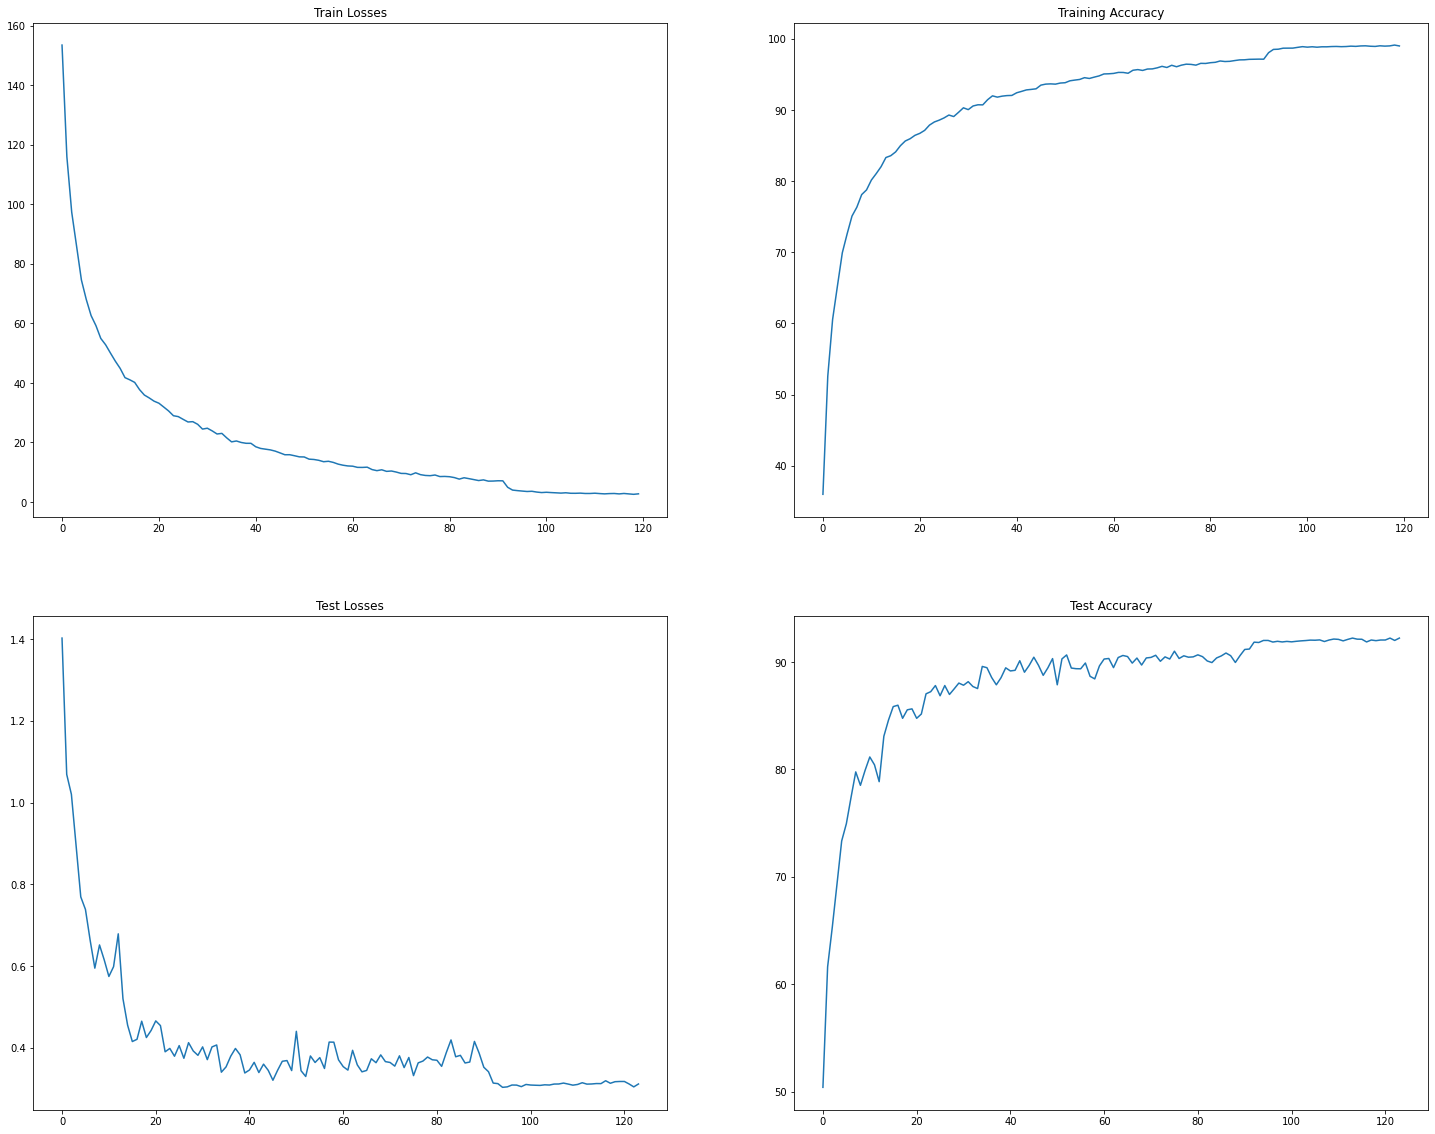

In [19]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)